# Anand Parekh - PG (210038281)

This notebook contains all code needed for training and testing the CNN, MLP and SVM. References, where applicable, are commented above the associated code.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 1: Loading images and labels

## 1.1: Loading Packages and Unzipping data

In [ ]:
!pip install skorch # For the CNN
!pip install opencv-python==4.5.5.64 ## For SIFT
!pip install opencv-contrib-python==4.5.5.64 ## For SIFT

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from skimage import img_as_ubyte, io, color
from sklearn import svm, metrics
import pickle
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from skorch import NeuralNetClassifier
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from skorch.callbacks import EarlyStopping
import seaborn as sns
import sys

In [ ]:
Path_After = 'CW_Folder_PG/Code'  
path = os.path.join('drive', 'My Drive', Path_After)
print(os.listdir(path))

['CV_CODE_ANAND.ipynb', '.DS_Store', '.ipynb_checkpoints']


The following 'unzip code' was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London.

In [ ]:
### REFERENCE ###
#Code in this cell (unzipping folder) was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London
Path_After = 'CW_Folder_PG/CW_Dataset' 
path = os.path.join('drive', 'My Drive', Path_After)
zip_path = os.path.join(path, 'CW_Dataset.zip')

!cp '{zip_path}' .

!yes|unzip -q CW_Dataset

!rm CW_Dataset.zip

Output hidden; open in https://colab.research.google.com to view.

## 1.2: Loading Training Data

The following image loading code was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London.

In [ ]:
### REFERENCE ###
# Loop in this cell (loading images) was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London

path= "CW_Dataset/train"

list1 = []

for file in sorted(os.listdir(path)): #adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London
    if file.endswith(".jpg"):
        list1.append(os.path.join(path, file))

x = [np.array(cv2.imread(i, 1)) for i in list1]

The following label reading code was composed with reference to this guide: https://riptutorial.com/tensorflow/example/27789/how-to-load-images-and-labels-from-a-txt-file

In [ ]:
### Reference ###
# Code in this cell (loading labels) was composed by following the below link
# https://riptutorial.com/tensorflow/example/27789/how-to-load-images-and-labels-from-a-txt-file
with open('CW_Dataset/labels/list_label_train.txt') as f:
    targets = f.readlines()

labels = []
for target in targets:
  label = target[-2] #Position of label in the line
  labels.append(label)

In [ ]:
pdlabels = pd.Series(labels)
pdlabels.value_counts() # There is a missing label which didn't get read.

4    4772
7    2523
5    1982
1    1290
3     717
6     705
2     281
        1
dtype: int64

There is a missing label. Further inspection shows this is the last label in the file

In [ ]:
# Last Testing label didn't get read therefore I update the label list manually

In [ ]:
labels[-1]

' '

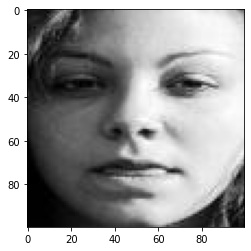

In [ ]:
fig, ax = plt.subplots()
ax.imshow(x[-1])

From looking at the files manually, I learnt the missing label should be '7'

In [ ]:
# Label should be 7
labels[-1] = '7'

In [ ]:
pdlabels = pd.Series(labels)
pdlabels.value_counts() # No more missing labels now shown from below output


4    4772
7    2524
5    1982
1    1290
3     717
6     705
2     281
dtype: int64

## 1.3: Loading Testing Data

The following image loading code was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London.

In [ ]:
###Reference###
# Loop in this cell (loading images) was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London

path= "CW_Dataset/test"

testlist = []

for testimage in sorted(os.listdir(path)): #adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London
    if file.endswith(".jpg"):
        testlist.append(os.path.join(path, testimage))

x_test = [np.array(cv2.imread(testimage, 1)) for testimage in testlist]

The following label reading code was composed with reference to this guide: https://riptutorial.com/tensorflow/example/27789/how-to-load-images-and-labels-from-a-txt-file

In [ ]:
###Reference###
# Code in this cell (loading labels) was composed by following the below link
# https://riptutorial.com/tensorflow/example/27789/how-to-load-images-and-labels-from-a-txt-file
with open('CW_Dataset/labels/list_label_test.txt') as f:
    testlabels = f.readlines()

y_test = []
for target in testlabels:
  label = target[-2] #Position of label in the line
  y_test.append(label)

Like in the training set, the last label didn't get read. I will update the labels manually again.



In [ ]:
pd.Series(y_test).value_counts()

4    1185
7     679
5     478
1     329
6     162
3     160
2      74
        1
dtype: int64

In [ ]:
# Last Testing label didn't get read therefore I update the list manually

In [ ]:
y_test[-1]

' '

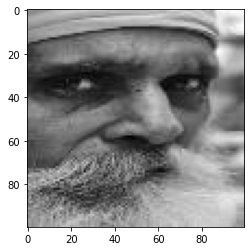

In [ ]:
fig, ax = plt.subplots()
ax.imshow(x_test[-1])

From looking at the files manually, I learnt the missing label should be '7'

In [ ]:
y_test[-1] = '7' 

In [ ]:
pd.Series(y_test).value_counts()

4    1185
7     680
5     478
1     329
6     162
3     160
2      74
dtype: int64

# 2: Fixing Class Imbalance Using Random Oversampling

In [ ]:
xnp = np.array(x)
print(xnp.shape)

(12271, 100, 100, 3)


I am required to reshape the image arrays to 2 dimensions for the imblearn function

In [ ]:
X = xnp.reshape(12271,3*100*100)


The following Random Oversampling code was composed with reference to this guide: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

In [ ]:
### Reference ###
#Code in this cell for RandomOverSampling was adapted from https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
from imblearn.over_sampling import RandomOverSampler
RoS = RandomOverSampler()
X, y = RoS.fit_resample(X, pdlabels)

In [ ]:
y.value_counts() # Class imbalance is now resolved.

5    4772
4    4772
1    4772
6    4772
2    4772
3    4772
7    4772
dtype: int64

In [ ]:
print('Old X length:', len(x), 'old y length', len(labels))
print('New X length:', len(X), 'New y length', len(y))

Old X length: 12271 old y length 12271
New X length: 33404 New y length 33404


# 3: CNN

**Training Method**:
To save resources and time, extensive hyper-parameter tuning will only be performed on 30%  of the training set only. 'Stratify' will be set to 'True' such that the class distribution is kept the same in this 30% sample. Gridsearch will be used to find the best performing hyper-parameters. This sample will be split into a further training and validation set automatically by scikit-learns GridSearchCV (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Cross validation is used to help identify overfitting and reduce overly optimistic validation accuracies. Once this is complete, the WHOLE training set will be used and split into training and validation sets automatically by Skorch; the best performing models from the previous gridsearch will be trained and validated on these sets. Out of these models, the single best performing model will be retrained on the WHOLE training set and is ready for testing.

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")          
print(device)

cuda


Adjusting data shape and data types for Skorch.

In [ ]:
X = X.reshape(33404,3,100,100)

In [ ]:
X = np.array(X, dtype=np.float32) 
y = np.array(y,dtype=np.int64)

The CNN outputs labels 0, 1, 2,3,4,5,6. Therefore, I adjust my y labels from 1,2,3,4,5,6,7 to the same range as the CNN output

In [ ]:
y = y-1

In [ ]:
print(y.min(), y.max())

0 6


The following CNN code was adapted from Lab_08.ipynb of the Computer Vision Module at City, University of London.

In [ ]:
### Reference ###
#This CNN Code was adapted from Lab_08.ipynb of the Computer Vision Module at City, University of London
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, units1 = 512, units2 = 256):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(7744, units1)
        self.fc2 = nn.Linear(units1, units2)
        self.fc3 = nn.Linear(units2, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 7744)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


classifier = Net()
classifier.to(device)
optimizer = optim.SGD(classifier.parameters(), lr=0.001, momentum=0.9)


I followed the skorch documentation to compose the following code:  https://skorch.readthedocs.io/en/stable/net.html

In [ ]:
### Reference ### 
#I followed the skorch documentation to compose this code ###
#link: https://skorch.readthedocs.io/en/stable/net.html
net = NeuralNetClassifier(
    classifier,
    max_epochs=20,
    criterion=torch.nn.CrossEntropyLoss(),batch_size=128, device = device, optimizer = torch.optim.SGD, optimizer__lr = 0.001, optimizer__momentum =0.9

)

In [ ]:
# Checking everything works
net.fit(X,y)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0091       0.1435        1.9487  4.4003
      2        1.9989       0.1432        1.9481  4.2948
      3        1.9963       0.1402        1.9481  4.3007
      4        1.9959       0.1416        1.9478  4.3410
      5        1.9946       0.1411        1.9477  4.3289
      6        1.9935       0.1417        1.9474  4.3930


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=7744, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=7, bias=True)
  ),
)

## 3.1: Extensive hyper-parameter tuning on smaller sample of training set
Reference: I followed the skorch documentation to compose the following gridsearch code.
Link: https://skorch.readthedocs.io/en/stable/net.html

In [ ]:
### Reference### 
#I followed the skorch documentation to compose this NeuralNetClassifier code ###
# link: https://skorch.readthedocs.io/en/stable/net.html
netGS = NeuralNetClassifier(
    classifier,
    max_epochs=100,
    criterion=torch.nn.CrossEntropyLoss(), callbacks=[EarlyStopping(patience = 10)], optimizer__lr = 0.001, optimizer__momentum = 0.1
)

Given the large training dataset size, the gridsearch will be performed on a small sample of the dataset. 

In [ ]:
X_, X_HP, y_, y_HP = train_test_split(X,y,test_size = 0.3,random_state = 2, shuffle=True, stratify=y) 


In [ ]:
XHP = torch.from_numpy(X_HP).float().to(device)
yHP = torch.from_numpy(y_HP).int().to(device)

In [ ]:
### Reference### 
#I followed the skorch documentation to compose this hyper-parameter space code ###
# link: https://skorch.readthedocs.io/en/stable/user/quickstart.html
Params_Ranges = {
    'module__units1': [64, 128, 512],
    'module__units2': [32, 64,128,256] 
}


In [ ]:
### Reference### 
# Following GridSearch code was made using scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
CNNgs1 = GridSearchCV(netGS, Params_Ranges, refit=False, error_score = 'raise', verbose = 3, cv =2)

In [ ]:
### Reference### 
# Following GridSearch code was made using scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
CNNgs1.fit(X_HP, y_HP)
print(CNNgs1.best_score_, CNNgs1.best_params_)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.2563       0.1496        1.9374  2.7915
      2        1.9331       0.1745        1.9250  2.8259
      3        1.9175       0.2104        1.9128  2.8561
      4        1.9004       0.2413        1.8977  2.8936
      5        1.8803       0.2473        1.8801  2.9046
      6        1.8568       0.2662        1.8588  2.8553
      7        1.8288       0.2782        1.8332  2.8481
      8        1.7947       0.2901        1.8051  2.8611
      9        1.7535       0.3011        1.7744  2.9154
     10        1.7094       0.3230        1.7563  2.8823
     11        1.6657       0.3500        1.7245  2.9450
     12        1.6243       0.3559        1.6935  2.8895
     13        1.5793       0.3908        1.6701  3.0953
     14        1.5381       0.3948        1.6547  2.9572
     15        1.4997      

## 3.2: Final Model Selection

The validation losses in **Step 3.1** were very poor. Therefore, in **Step 3.3**, I manually altered hyper-parameters and observed the performance of the model using the **whole** dataset and Skorch's automatic train-validation split. The best parameters found are below:
- Fully connected layer architecture = (120,84,64,32)
- lr = 0.001
- momentum = 0.1
- Epochs = 50

Output of the training with these parameters is shown in **Step 3.3**

## 3.3 Final Model Training

In [ ]:
### Reference### 
###This CNN Code was adapted from Lab 08.ipynb of the Computer Vision Module at City, University of London
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, units1 = 120, units2 = 84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(7744, units1)
        self.fc2 = nn.Linear(units1, units2)
        self.fc3 = nn.Linear(units2, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 7744)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


classifier = Net()
#classifier.to(device)
optimizer = optim.SGD(classifier.parameters(), lr=0.001, momentum=0.1)

In [ ]:
### Reference### 
#I followed the skorch documentation to compose this NeuralNetClassifier code ###
# link: https://skorch.readthedocs.io/en/stable/net.html
netFinal = NeuralNetClassifier(
    classifier,
    max_epochs=50,
    criterion=torch.nn.CrossEntropyLoss(),batch_size=128, optimizer = torch.optim.SGD, optimizer__lr = 0.001, optimizer__momentum =0.1

) #device=device

**NOTE:**
I was experiencing a problem where if I don't use scikit-learn's train_test_split on the data, my losses and perfomance are much worse. I am not sure why. Therefore, I sacrifice 0.023% of training set and pass it through train_test_split. I demonstrate the difference in performance below. I believe it is an issue associated with the skorch library.

USING data output from the test_train_split function.

In [ ]:
X_train, xnotused, y_train, ynotused = train_test_split(X,y,test_size = 0.00023,random_state = 2, shuffle=True, stratify=y) 


In [ ]:
netFinal = netFinal.fit(X_train,y_train)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.9306       0.2558        1.8993  19.2553
      2        1.8684       0.3198        1.8167  18.7280
      3        1.7856       0.3555        1.7277  18.0365
      4        1.6936       0.4111        1.6209  18.5060
      5        1.5827       0.4464        1.5193  18.6299
      6        1.4685       0.4897        1.4092  18.7571
      7        1.3636       0.5129        1.3380  18.6063
      8        1.2797       0.5506        1.2448  18.9471
      9        1.1961       0.5680        1.1938  18.6058
     10        1.1217       0.5910        1.1265  18.6270
     11        1.0399       0.6168        1.0544  18.6468
     12        0.9682       0.6470        0.9922  18.5559
     13        0.9051       0.6638        0.9329  18.5017
     14        0.8320       0.6828        0.8795  18.0403
     15        0.7834       0.7076        0.8229  18.2240
     16       

In [ ]:
### REFERENCE ###
# Code for saving the model was adapted Skorch Documentation
# Link: https://skorch.readthedocs.io/en/stable/user/save_load.html
with open('CNNFinal.pkl', 'wb') as f:
    pickle.dump(netFinal, f)

In [ ]:
### REFERENCE ###
# Calculating model size: https://stackoverflow.com/questions/45601897/how-to-calculate-the-actual-size-of-a-fit-trained-model-in-sklearn
p = pickle.dumps(netFinal)
print(sys.getsizeof(p), 'bytes')

12289031 bytes


Training the model with the normal X and y and NOT USING test_train_split.

In [ ]:
netNoTrainTestSplit = netFinal.fit(X,y)

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.2722       0.1690        1.9241  19.4467
      2        0.7608       0.1428       19.5976  18.6760
      3        0.8038       0.1428       12.9863  18.6338
      4        0.6961       0.1429       11.9308  18.6749
      5        0.7289       0.1426        8.0624  18.6706
      6        0.8333       0.1426        4.6759  18.9047
      7        0.8795       0.1482        2.4161  21.1467
      8        0.9130       0.1630        3.0280  18.6767
      9        0.6758       0.1509        4.9233  18.9357
     10        0.7019       0.1847        2.8717  18.6686
     11        0.6119       0.1513        3.2741  18.5670
     12        0.6697       0.1548        3.7705  18.4227
     13        0.7247       0.1431        5.9753  18.7729
     14        0.6825       0.1431        5.8719  18

# 4: CNN Testing

In [ ]:
# Run the CNN template architecture in section 3.3 for loading the model to work
# Loading model again for convenience in future runs
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CW_Folder_PG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
netFinal = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','CNNFinal.pkl'))

Adjusting x_test and y_test to be compatible with the CNN 

In [ ]:
x_test = np.array(x_test, dtype=np.float32) 
CNNy_test = np.array(y_test,dtype=np.int64)-1
x_test = x_test.reshape(3068, 3, 100,100)

In [ ]:
#Model execution time
start = time.time()
y_testpred = netFinal.predict(x_test)
end = time.time()
totaltime = (end - start)
print(totaltime)

0.827237606048584


Converting the labels to their corresponding strings.

In [ ]:
keyCNN = {0:'Surprise', 1:'Fear', 2:'Disgust',3:'Happiness', 4:'Sadness', 5:'Anger', 6:'Neutral'}
true_label = []
pred_label = []
for i in CNNy_test:
  true_label.append(keyCNN[i])
for i in y_testpred:
  pred_label.append(keyCNN[i])


In [ ]:
### REFERENCE ###
### The classification report code was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London ###
print(f"""Classification report for classifier {netFinal}:
      {metrics.classification_report(true_label, pred_label)}\n""")

Classification report for classifier <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=7744, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=64, bias=True)
    (fc4): Linear(in_features=64, out_features=32, bias=True)
    (fc5): Linear(in_features=32, out_features=7, bias=True)
  ),
):
                    precision    recall  f1-score   support

       Anger       0.45      0.43      0.44       162
     Disgust       0.33      0.29      0.31       160
        Fear       0.54      0.42      0.47        74
   Happiness       0.80      0.78      0.79      1185
     Neutral       0.55      0.59      0.57       680
     Sadness       0.42 

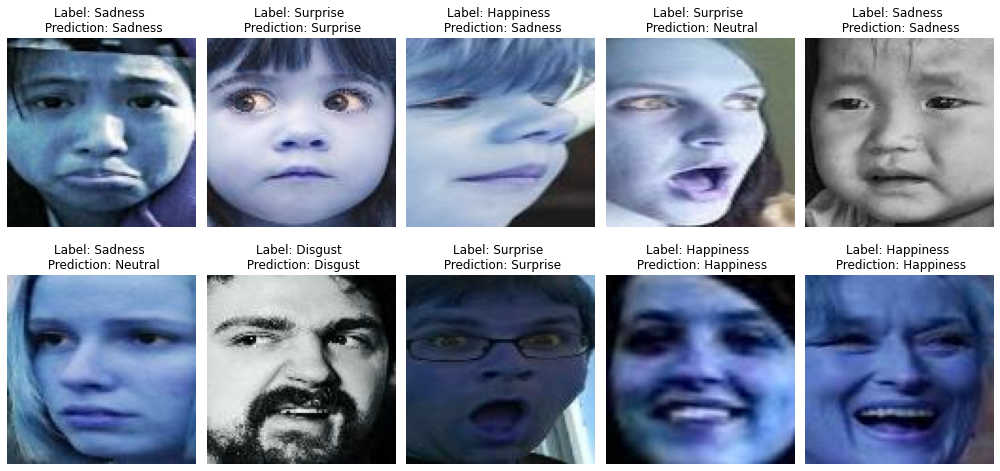

In [ ]:
### REFERENCE ### 
# The following Display code was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()
for i in range(10):
    ax[i].imshow(x_test[i])
    ax[i].set_title(f'Label: {true_label[i]} \n Prediction: {pred_label[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.savefig('CNNqual.png')
plt.show()

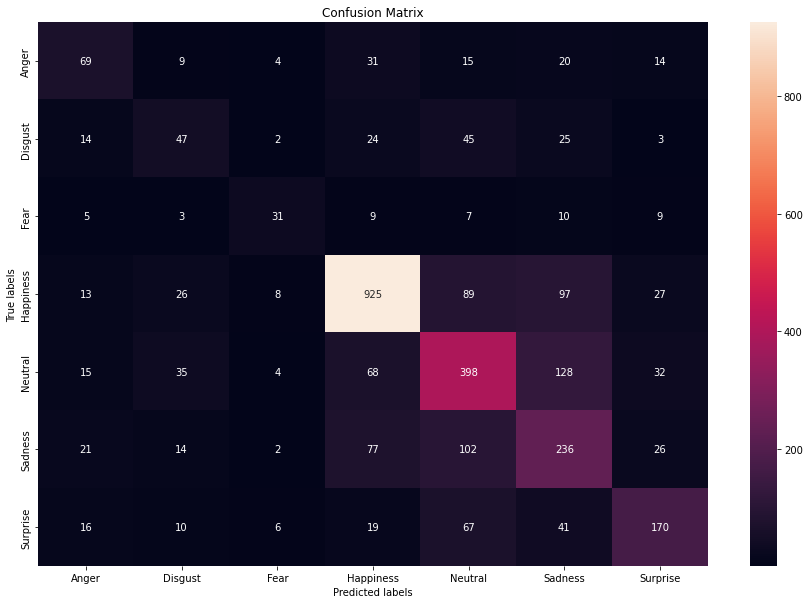

In [ ]:
### REFERENCE ###
# Code for confusion matrix adapted from https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels#
cm = metrics.confusion_matrix(true_label, pred_label)
fig, ax= plt.subplots(figsize=(15,10))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']); ax.yaxis.set_ticklabels(['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']);
plt.savefig('CNNCm.png')

# 5: SIFT

In [ ]:
X = X.reshape(33404, 100, 100, 3)

The following SIFT, KMeans and histogram of codewords code was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London

In [ ]:
### Reference ###
# The following SIFT, Kmeans and histogram of codewords code was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London
sift = cv2.SIFT_create()

Descriptors = []
labels = []

for index in range(len(X)):
    image = img_as_ubyte(color.rgb2gray(X[index]))
    keypoint, descriptor = sift.detectAndCompute(image, None)


    if descriptor is not None:
        Descriptors.append(descriptor)
        labels.append(y[index])

Descriptors_array = np.vstack(Descriptors)

In [ ]:
###REFERENCE ###
# The following KMeans code was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London
# 10 X 7 classes = 70 clusters
bs = Descriptors_array.shape[0] // 4
K = MiniBatchKMeans(n_clusters=70, batch_size=bs).fit(Descriptors_array)

In [ ]:
###REFERENCE ###
# The following model saving code was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London
dump(K, 'Kmeans.joblib') 

['Kmeans.joblib']

In [ ]:
# Loading model again for convenience in future runs
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CW_Folder_PG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
K = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','Kmeans.joblib'))

### REFERENCE ###
# Calculating model size: https://stackoverflow.com/questions/45601897/how-to-calculate-the-actual-size-of-a-fit-trained-model-in-sklearn
p = pickle.dumps(K)
print(sys.getsizeof(p), 'bytes')

8275901 bytes


In [ ]:
### REFERENCE ###
# The following histogram of codeword codes was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London
Histogram = []
index_list = []

for descriptor in Descriptors:
    zero = np.zeros(70)

    index = K.predict(descriptor)
    index_list.append(index)
    for f in index:
        zero[f] = zero[f] + (1 / len(descriptor))
    Histogram.append(zero)

histogramArray = np.vstack(Histogram)

# 6: SVM 

**Training Method**:
To save resources and time, extensive hyper-parameter tuning will only be performed on 30%  of the training set only. 'Stratify' will be set to 'True' such that the class distribution is kept the same in this sample. Gridsearch will be used to find the best performing hyper-parameters. This 30% sample will be split into a further training and validation set automatically by scikit-learns GridSearchCV (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Cross validation is used to help identify overfitting and reduce overly optimistic validation accuracies. Once this is complete, the WHOLE training set will be used; the WHOLE training set will be split into 80% training and 20% Validation set. The best performing models from the previous gridsearch will be trained and validated on these sets. Out of these models, the single best performing model will be retrained on the WHOLE training set and is ready for testing.

## 6.1: Extensive hyper-parameter tuning on smaller sample of training set

Code for gridsearch made by following scikit-learn guide: 
 https://scikit-learn.org/stable/modules/grid_search.html 

In [ ]:
X_, X_HP, y_, y_HP = train_test_split(histogramArray,labels,test_size = 0.3,random_state = 2, shuffle=True, stratify=labels) 


In [ ]:
svmdefault = svm.SVC()

In [ ]:
### REFERENCE ###
### Code for gridsearch adapted from scikit-learn guide ###
### link: https://scikit-learn.org/stable/modules/grid_search.html ###
Param_Ranges = [
  {'kernel': ['linear'],'C': [0.1,1, 10, 100, 1000]},
  {'gamma': [0.1, 0.01,0.001, 0.0001], 'kernel': ['rbf'],'C': [0.1, 1, 10, 100, 1000]}, 
  {'kernel': ['sigmoid'],'C': [0.1,1, 10, 100, 1000], 'gamma': [0.1, 0.01,0.001, 0.0001]},
   {'kernel': ['poly'],'C': [0.1,1, 10, 100, 1000], 'gamma': [0.1, 0.01,0.001, 0.0001], 'degree':[1,2,3,4,5,6]}
 ]

In [ ]:
### REFERENCE ###
### Code for gridsearch adapted from scikit-learn guide in link below ###
### https://scikit-learn.org/stable/modules/grid_search.html ###
GS1 = GridSearchCV(svmdefault,Param_Ranges, refit=False, verbose=3, cv=3,
    error_score="raise" , scoring = 'accuracy')

In [ ]:
print(GS1.fit(X_HP, y_HP))

Fitting 3 folds for each of 165 candidates, totalling 495 fits
[CV 1/3] END ..............C=0.1, kernel=linear;, score=0.143 total time=   6.5s
[CV 2/3] END ..............C=0.1, kernel=linear;, score=0.147 total time=   6.5s
[CV 3/3] END ..............C=0.1, kernel=linear;, score=0.143 total time=   6.9s
[CV 1/3] END ................C=1, kernel=linear;, score=0.290 total time=   7.6s
[CV 2/3] END ................C=1, kernel=linear;, score=0.278 total time=   7.6s
[CV 3/3] END ................C=1, kernel=linear;, score=0.277 total time=   6.3s
[CV 1/3] END ...............C=10, kernel=linear;, score=0.308 total time=   5.9s
[CV 2/3] END ...............C=10, kernel=linear;, score=0.294 total time=   5.9s
[CV 3/3] END ...............C=10, kernel=linear;, score=0.301 total time=   6.6s
[CV 1/3] END ..............C=100, kernel=linear;, score=0.304 total time=   7.1s
[CV 2/3] END ..............C=100, kernel=linear;, score=0.299 total time=   7.2s
[CV 3/3] END ..............C=100, kernel=linea

In [ ]:
### REFERENCE ###
# Following code was made using scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
print(GS1.best_score_, GS1.best_params_)
GS1df = pd.DataFrame(GS1.cv_results_)

0.30872137770754327 {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}


In [ ]:
GS1df.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,param_degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
21,9.043085,0.032597,2.583781,0.023023,1000,rbf,0.1,NaN,"{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}",0.316452,0.298561,0.311151,0.308721,0.007503,1
17,7.062052,0.040746,2.604666,0.031017,100,rbf,0.1,NaN,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.311957,0.302458,0.303058,0.305824,0.004343,2
142,5.001990,0.026905,1.254383,0.002591,1000,poly,0.01,1,"{'C': 1000, 'degree': 1, 'gamma': 0.01, 'kerne...",0.308361,0.294664,0.300959,0.301328,0.005598,3
117,4.981880,0.035889,1.254087,0.012175,100,poly,0.1,1,"{'C': 100, 'degree': 1, 'gamma': 0.1, 'kernel'...",0.308361,0.294664,0.300959,0.301328,0.005598,3
42,7.084394,0.033211,1.777130,0.002876,1000,sigmoid,0.01,NaN,"{'C': 1000, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.308361,0.294664,0.300659,0.301228,0.005606,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,5.728621,0.034274,1.298073,0.005795,10,poly,0.1,3,"{'C': 10, 'degree': 3, 'gamma': 0.1, 'kernel':...",0.142943,0.142986,0.142986,0.142971,0.000020,81
100,5.693386,0.045363,1.292714,0.004057,10,poly,0.0001,2,"{'C': 10, 'degree': 2, 'gamma': 0.0001, 'kerne...",0.142943,0.142986,0.142986,0.142971,0.000020,81
99,5.749331,0.022024,1.292334,0.007485,10,poly,0.001,2,"{'C': 10, 'degree': 2, 'gamma': 0.001, 'kernel...",0.142943,0.142986,0.142986,0.142971,0.000020,81
74,5.715980,0.042861,1.296674,0.009259,1,poly,0.01,2,"{'C': 1, 'degree': 2, 'gamma': 0.01, 'kernel':...",0.142943,0.142986,0.142986,0.142971,0.000020,81


The best models are below

In [ ]:
SVM1 = svm.SVC(kernel = 'rbf', gamma = 0.1, C =1000 )
SVM2 = svm.SVC(kernel = 'rbf', gamma = 0.1, C = 100)
SVM3 = svm.SVC(kernel =  'poly', degree = 1, gamma = 0.01, C = 1000)
SVM4 = svm.SVC(kernel =  'poly', degree = 1, gamma = 0.01, C = 100)
SVM5 = svm.SVC(kernel = 'sigmoid', gamma = 0.01, C =1000 )

## 6.2: Final Model Selection
The best models will each be fit on 80% of the WHOLE training set and validated on the remaining 20%. The best performing model of out these will be retrained on the WHOLE training set.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(histogramArray,labels,test_size = 0.2,random_state = 2, shuffle=True, stratify=labels) 

SVM1

In [ ]:
SVM1a = SVM1.fit(X_train, y_train)

In [ ]:
SVM1y_pred = SVM1.predict(X_valid)

In [ ]:
### REFERENCE ###
### The classification report code was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London ###
print(f"""Classification report for classifier {SVM1a}:
      {metrics.classification_report(y_valid, SVM1y_pred)}\n""")

Classification report for classifier SVC(C=1000, gamma=0.1):
                    precision    recall  f1-score   support

           1       0.34      0.39      0.36       954
           2       0.36      0.51      0.42       950
           3       0.32      0.33      0.32       953
           4       0.31      0.29      0.30       954
           5       0.28      0.23      0.25       955
           6       0.33      0.33      0.33       955
           7       0.33      0.21      0.26       952

    accuracy                           0.33      6673
   macro avg       0.32      0.33      0.32      6673
weighted avg       0.32      0.33      0.32      6673




SVM2

In [ ]:
### REFERENCE ###
### The classification report code was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London ###
SVM2a = SVM2.fit(X_train, y_train)
SVM2y_pred = SVM2.predict(X_valid)
print(f"""Classification report for classifier {SVM2a}:
      {metrics.classification_report(y_valid, SVM2y_pred)}\n""")

Classification report for classifier SVC(C=100, gamma=0.1):
                    precision    recall  f1-score   support

           1       0.33      0.36      0.34       954
           2       0.33      0.45      0.39       950
           3       0.30      0.32      0.31       953
           4       0.31      0.30      0.30       954
           5       0.24      0.21      0.23       955
           6       0.28      0.27      0.27       955
           7       0.29      0.19      0.23       952

    accuracy                           0.30      6673
   macro avg       0.30      0.30      0.30      6673
weighted avg       0.30      0.30      0.30      6673




SVM3

In [ ]:
### REFERENCE ###
### The classification report code was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London ###
SVM3a = SVM3.fit(X_train, y_train)
SVM3y_pred = SVM3.predict(X_valid)
print(f"""Classification report for classifier {SVM3a}:
      {metrics.classification_report(y_valid, SVM3y_pred)}\n""")

Classification report for classifier SVC(C=1000, degree=1, gamma=0.01, kernel='poly'):
                    precision    recall  f1-score   support

           1       0.33      0.35      0.34       954
           2       0.33      0.42      0.37       950
           3       0.29      0.31      0.30       953
           4       0.30      0.30      0.30       954
           5       0.25      0.21      0.23       955
           6       0.27      0.26      0.27       955
           7       0.25      0.19      0.22       952

    accuracy                           0.29      6673
   macro avg       0.29      0.29      0.29      6673
weighted avg       0.29      0.29      0.29      6673




SVM4

In [ ]:
### REFERENCE ###
### The classification report code was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London ###
SVM4a = SVM4.fit(X_train, y_train)
SVM4y_pred = SVM4.predict(X_valid)
print(f"""Classification report for classifier {SVM4a}:
      {metrics.classification_report(y_valid, SVM4y_pred)}\n""")

Classification report for classifier SVC(C=100, degree=1, gamma=0.01, kernel='poly'):
                    precision    recall  f1-score   support

           1       0.35      0.35      0.35       954
           2       0.31      0.40      0.35       950
           3       0.28      0.34      0.31       953
           4       0.31      0.29      0.30       954
           5       0.23      0.19      0.21       955
           6       0.29      0.26      0.28       955
           7       0.25      0.20      0.22       952

    accuracy                           0.29      6673
   macro avg       0.29      0.29      0.29      6673
weighted avg       0.29      0.29      0.29      6673




SVM5

In [ ]:
### REFERENCE ###
### The classification report code was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London ###
SVM5a = SVM5.fit(X_train, y_train)
SVM5y_pred = SVM5.predict(X_valid)
print(f"""Classification report for classifier {SVM5a}:
      {metrics.classification_report(y_valid, SVM5y_pred)}\n""")

Classification report for classifier SVC(C=1000, gamma=0.01, kernel='sigmoid'):
                    precision    recall  f1-score   support

           1       0.33      0.35      0.34       954
           2       0.33      0.42      0.37       950
           3       0.29      0.31      0.30       953
           4       0.30      0.30      0.30       954
           5       0.25      0.21      0.23       955
           6       0.27      0.26      0.27       955
           7       0.25      0.20      0.22       952

    accuracy                           0.29      6673
   macro avg       0.29      0.29      0.29      6673
weighted avg       0.29      0.29      0.29      6673




SVM1 was the best model.

## 6.3 Final SVM training

In [ ]:
SVMFinal = SVM1.fit(histogramArray,labels)

In [ ]:
###REFERENCE ###
# The following model saving code was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London
dump(SVMFinal, 'SVMFinal.joblib') 

['SVMFinal.joblib']

In [ ]:
# Calculate model size https://stackoverflow.com/questions/45601897/how-to-calculate-the-actual-size-of-a-fit-trained-model-in-sklearn
p = pickle.dumps(SVMFinal)
print(sys.getsizeof(p), 'bytes')

21259073 bytes


#7: SVM Testing

In [ ]:
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CW_Folder_PG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
SVMFinal = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','SVMFinal.joblib'))
K = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','Kmeans.joblib'))

The following SIFT, KMeans and histogram of codewords code was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London

In [ ]:
### REFERENCE ###
# The following SIFT, Kmeans and histogram of codewords code was adapted from Lab_07.ipynb 
###Reference: LAB 7 CODE of Computer Vision Module###
start = time.time()
Hist = []
sift = cv2.SIFT_create()
for index in range(len(x_test)):
    image = img_as_ubyte(color.rgb2gray(x_test[index]))
    keypoint, descriptor = sift.detectAndCompute(image, None)

    if descriptor is not None:
        hist = np.zeros(70)

        idx = K.predict(descriptor)

        for j in idx:
            hist[j] = hist[j] + (1 / len(descriptor))

        Hist.append(hist)

    else:
        Hist.append(None)

idx_not_empty = [index for index, value in enumerate(Hist) if value is not None]
Hist = [Hist[index] for index in idx_not_empty]
y_test = [y_test[index] for index in idx_not_empty]
histarray = np.vstack(Hist)
end = time.time()
SIFTTIME = (end - start)

In [ ]:
#Model execution time
start = time.time()
y_pred = SVMFinal.predict(histarray).tolist()
end = time.time()
totaltime = (SIFTTIME + end - start)
print(totaltime)

40.87208104133606


In [ ]:
key = {'1':'Surprise', '2':'Fear', '3':'Disgust','4':'Happiness', '5':'Sadness', '6':'Anger', '7':'Neutral'}
true_label = []
pred_label = []
for i in y_test:
  true_label.append(key[i])
for i in y_pred:
  pred_label.append(key[i])


In [ ]:
### REFERENCE ###
### The classification report code was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London ###
print(f"""Classification report for classifier {SVMFinal}:
      {metrics.classification_report(true_label, pred_label)}\n""")

Classification report for classifier SVC(C=1000, gamma=0.1):
                    precision    recall  f1-score   support

       Anger       0.14      0.32      0.19       161
     Disgust       0.06      0.19      0.09       160
        Fear       0.06      0.36      0.11        74
   Happiness       0.63      0.28      0.39      1183
     Neutral       0.38      0.20      0.26       680
     Sadness       0.26      0.21      0.23       478
    Surprise       0.25      0.39      0.31       329

    accuracy                           0.26      3065
   macro avg       0.25      0.28      0.23      3065
weighted avg       0.41      0.26      0.29      3065




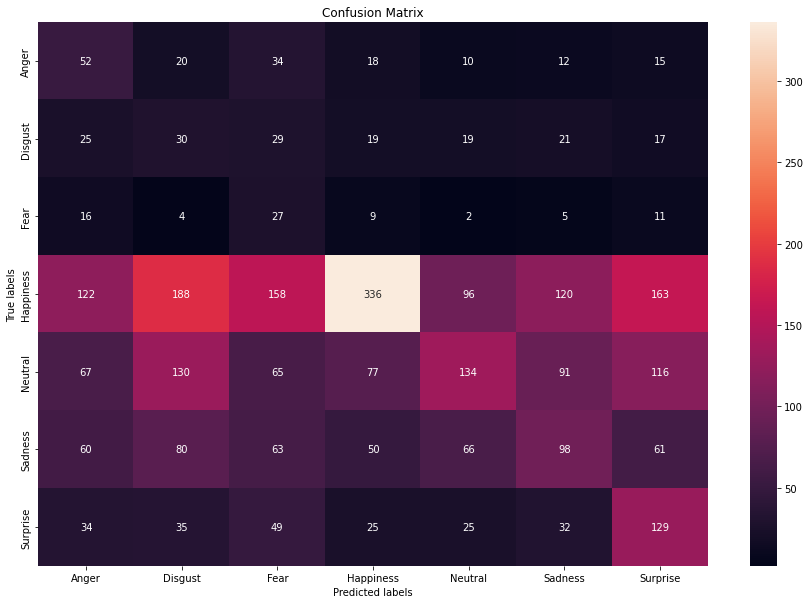

In [ ]:
### REFERENCE ###
# Code for confusion matrix adapted from https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels#
cm = metrics.confusion_matrix(true_label, pred_label)
fig, ax= plt.subplots(figsize=(15,10))
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']); ax.yaxis.set_ticklabels(['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']);
plt.savefig('SVMCm.png')

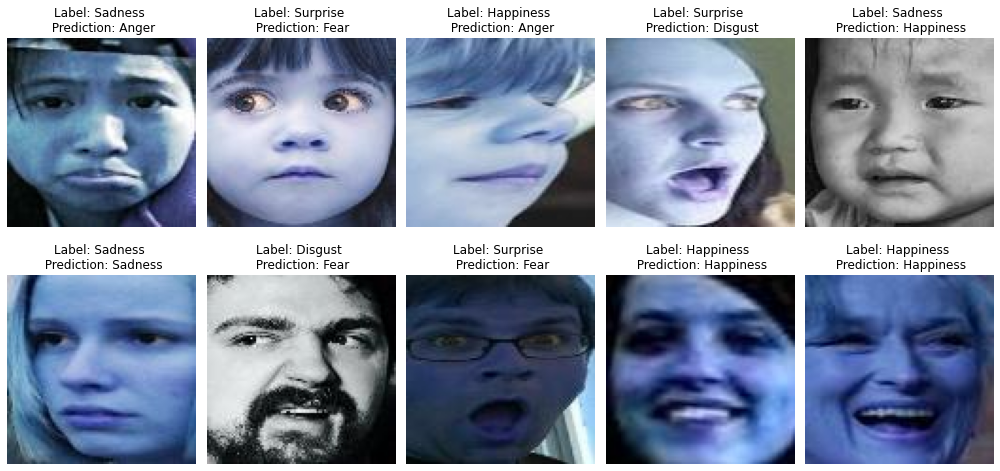

In [ ]:
### REFERENCE ###
# The following Image Display code was adapted from Lab_07 of Computer Vision Module at City, University of London
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(x_test[i])
    ax[i].set_title(f'Label: {true_label[i]} \n Prediction: {pred_label[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.savefig('SVMQual.png')
plt.show()

In [ ]:
### REFERENCE ###
### The classification report code was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London ###
print(f"""Classification report for classifier {SVMFinal}:
      {metrics.classification_report(y_test, y_pred)}\n""")

Classification report for classifier SVC(C=1000, gamma=0.1):
                    precision    recall  f1-score   support

           1       0.24      0.36      0.29       329
           2       0.07      0.43      0.12        74
           3       0.08      0.22      0.12       160
           4       0.60      0.31      0.41      1183
           5       0.24      0.21      0.22       478
           6       0.14      0.32      0.20       161
           7       0.38      0.18      0.24       680

    accuracy                           0.27      3065
   macro avg       0.25      0.29      0.23      3065
weighted avg       0.39      0.27      0.30      3065




# 8: MLP

**Training Method**:
To save resources and time, extensive hyper-parameter tuning will only be performed on 30%  of the training set only. 'Stratify' will be set to 'True' such that the class distribution is kept the same in this sample. Gridsearch will be used to find the best performing hyper-parameters. This sample will be split into a further training and validation set automatically by scikit-learns GridSearchCV (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Cross validation is used to help identify overfitting and reduce overly optimistic validation accuracies. Determing a good MLP architecture requires significant trial and error, therefore, I will repeat gridsearches updating the parameter ranges based on the good performing hyper-parameter in previous gridsearches 

Once this is complete, the WHOLE training set will be used; the WHOLE training set will be split into 80% training and 20% Validation set. The best perfoming models from the previous gridsearch will be trained and validated on these sets. Out of these models, the single best performing model will be retrained on the WHOLE training set and is ready for testing.

## 8.1: Extensive hyper-parameter tuning on small sample of training set

Using Gridsearch to find best MLP parameters.
Code adapted from: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html and https://panjeh.medium.com/scikit-learn-hyperparameter-optimization-for-mlpclassifier-4d670413042b

In [ ]:
MLP1 = MLPClassifier(early_stopping = True)

In [ ]:
### REFERENCE ###
### The paramater space dictionary below was made by following guides in below links ###
### link 1: https://scikit-learn.org/stable/modules/grid_search.html ###
### link 2: https://panjeh.medium.com/scikit-learn-hyperparameter-optimization-for-mlpclassifier-4d670413042b ###
Param_Ranges = {
    'activation': ['logistic', 'relu'],
    'learning_rate': ['adaptive', 'constant'],
    'solver': ['adam', 'sgd'],
    'hidden_layer_sizes': [(8,16),(8,16,32), (32,32), (128,128), (8,128), (128,8,64)],
    'alpha': [0.0005,0.001, 0.01]
}

In [ ]:
# Following code was made using scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
MLPGS1 = GridSearchCV(MLP1,Param_Ranges, refit=False, verbose=3, cv=2,
    error_score="raise" , scoring = 'accuracy')

In [ ]:
print(MLPGS1.fit(X_HP, y_HP))

Fitting 2 folds for each of 144 candidates, totalling 288 fits
[CV 1/2] END activation=logistic, alpha=0.0005, hidden_layer_sizes=(8, 16), learning_rate=adaptive, solver=adam;, score=0.142 total time=   1.2s
[CV 2/2] END activation=logistic, alpha=0.0005, hidden_layer_sizes=(8, 16), learning_rate=adaptive, solver=adam;, score=0.148 total time=   0.9s
[CV 1/2] END activation=logistic, alpha=0.0005, hidden_layer_sizes=(8, 16), learning_rate=adaptive, solver=sgd;, score=0.143 total time=   3.3s
[CV 2/2] END activation=logistic, alpha=0.0005, hidden_layer_sizes=(8, 16), learning_rate=adaptive, solver=sgd;, score=0.143 total time=   3.1s
[CV 1/2] END activation=logistic, alpha=0.0005, hidden_layer_sizes=(8, 16), learning_rate=constant, solver=adam;, score=0.143 total time=   0.6s
[CV 2/2] END activation=logistic, alpha=0.0005, hidden_layer_sizes=(8, 16), learning_rate=constant, solver=adam;, score=0.210 total time=   1.4s
[CV 1/2] END activation=logistic, alpha=0.0005, hidden_layer_sizes=(8

MLPGS1 didn't try Relu activation, therefore, I will repeat the gridsearch for only Relu (MLPGS2).

In [ ]:
### REFERENCE ###
### The paramater space dictionary below was made by following guides in below links ###
### link 1: https://scikit-learn.org/stable/modules/grid_search.html ###
### link 2: https://panjeh.medium.com/scikit-learn-hyperparameter-optimization-for-mlpclassifier-4d670413042b ###
Param_Ranges = {
    'activation': ['relu'],
    'learning_rate': ['adaptive', 'constant'],
    'solver': ['adam', 'sgd'],
    'hidden_layer_sizes': [(8,16),(8,16,32), (32,32), (128,128), (8,128), (128,8,64)],
    'alpha': [0.0005,0.001, 0.01]
}

In [ ]:
# Following code was made using scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
MLPGS2 = GridSearchCV(MLP1,Param_Ranges, refit=False, verbose=3, cv=3,
    error_score="raise" , scoring = 'accuracy')

In [ ]:
print(MLPGS2.fit(X_HP, y_HP))

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END activation=relu, alpha=0.0005, hidden_layer_sizes=(8, 16), learning_rate=adaptive, solver=adam;, score=0.250 total time=   4.2s
[CV 2/3] END activation=relu, alpha=0.0005, hidden_layer_sizes=(8, 16), learning_rate=adaptive, solver=adam;, score=0.260 total time=   3.6s
[CV 3/3] END activation=relu, alpha=0.0005, hidden_layer_sizes=(8, 16), learning_rate=adaptive, solver=adam;, score=0.225 total time=   1.9s
[CV 1/3] END activation=relu, alpha=0.0005, hidden_layer_sizes=(8, 16), learning_rate=adaptive, solver=sgd;, score=0.143 total time=   2.3s
[CV 2/3] END activation=relu, alpha=0.0005, hidden_layer_sizes=(8, 16), learning_rate=adaptive, solver=sgd;, score=0.143 total time=   2.3s
[CV 3/3] END activation=relu, alpha=0.0005, hidden_layer_sizes=(8, 16), learning_rate=adaptive, solver=sgd;, score=0.142 total time=   2.2s
[CV 1/3] END activation=relu, alpha=0.0005, hidden_layer_sizes=(8, 16), learning_rate=constant,

In [ ]:
# Following code was made using scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
print(MLPGS2.best_score_, MLPGS2.best_params_)
GS2df = pd.DataFrame(MLPGS2.cv_results_)

0.3886555125093812 {'activation': 'relu', 'alpha': 0.0005, 'hidden_layer_sizes': (128, 8, 64), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [ ]:
GS2df.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
20,10.963203,3.021560,0.019267,0.003408,relu,0.0005,"(128, 8, 64)",adaptive,adam,"{'activation': 'relu', 'alpha': 0.0005, 'hidde...",0.335631,0.394185,0.436151,0.388656,0.041223,1
12,12.371003,8.753808,0.022189,0.001281,relu,0.0005,"(128, 128)",adaptive,adam,"{'activation': 'relu', 'alpha': 0.0005, 'hidde...",0.374588,0.459233,0.288070,0.373963,0.069878,2
22,8.971146,4.065040,0.016368,0.000365,relu,0.0005,"(128, 8, 64)",constant,adam,"{'activation': 'relu', 'alpha': 0.0005, 'hidde...",0.430027,0.384892,0.277578,0.364166,0.063939,3
14,10.767637,6.172035,0.020239,0.000427,relu,0.0005,"(128, 128)",constant,adam,"{'activation': 'relu', 'alpha': 0.0005, 'hidde...",0.308960,0.427758,0.348022,0.361580,0.049437,4
46,8.481449,1.832085,0.016600,0.000402,relu,0.001,"(128, 8, 64)",constant,adam,"{'activation': 'relu', 'alpha': 0.001, 'hidden...",0.361103,0.387290,0.319245,0.355879,0.028024,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.834359,0.210311,0.010949,0.000240,relu,0.01,"(8, 128)",constant,sgd,"{'activation': 'relu', 'alpha': 0.01, 'hidden_...",0.140545,0.142686,0.143285,0.142172,0.001176,68
5,3.269463,0.318625,0.008516,0.000223,relu,0.0005,"(8, 16, 32)",adaptive,sgd,"{'activation': 'relu', 'alpha': 0.0005, 'hidde...",0.143242,0.137590,0.142986,0.141273,0.002606,69
9,5.849913,3.776175,0.011375,0.003394,relu,0.0005,"(32, 32)",adaptive,sgd,"{'activation': 'relu', 'alpha': 0.0005, 'hidde...",0.135751,0.142986,0.144784,0.141173,0.003904,70
57,3.932261,0.296233,0.009220,0.000275,relu,0.01,"(32, 32)",adaptive,sgd,"{'activation': 'relu', 'alpha': 0.01, 'hidden_...",0.136949,0.137590,0.148681,0.141073,0.005386,71


In [ ]:
### REFERENCE ###
### The paramater space dictionary below was made by following guides in below links ###
### link 1: https://scikit-learn.org/stable/modules/grid_search.html ###
### link 2: https://panjeh.medium.com/scikit-learn-hyperparameter-optimization-for-mlpclassifier-4d670413042b ###
MLP2 = MLPClassifier(early_stopping = True, max_iter=500, activation='relu', alpha=0.0005, solver = 'adam')
Param_Ranges = {
    'learning_rate': ['adaptive', 'constant'],
    'hidden_layer_sizes': [(128,128,128), (256,128,128), (128,32,64), (512,8,64), (32,64,128,64), (8,128,512,8) ]
    
}

In [ ]:
# Following code was made using scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
MLPGS3 = GridSearchCV(MLP2,Param_Ranges, refit=False, verbose=3, cv=3,
    error_score="raise" , scoring = 'accuracy')

In [ ]:
print(MLPGS3.fit(X_HP, y_HP))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END hidden_layer_sizes=(128, 128, 128), learning_rate=adaptive;, score=0.430 total time=  21.7s
[CV 2/3] END hidden_layer_sizes=(128, 128, 128), learning_rate=adaptive;, score=0.462 total time=  21.0s
[CV 3/3] END hidden_layer_sizes=(128, 128, 128), learning_rate=adaptive;, score=0.469 total time=  21.6s
[CV 1/3] END hidden_layer_sizes=(128, 128, 128), learning_rate=constant;, score=0.459 total time=  24.2s
[CV 2/3] END hidden_layer_sizes=(128, 128, 128), learning_rate=constant;, score=0.409 total time=  12.9s
[CV 3/3] END hidden_layer_sizes=(128, 128, 128), learning_rate=constant;, score=0.500 total time=  31.9s
[CV 1/3] END hidden_layer_sizes=(256, 128, 128), learning_rate=adaptive;, score=0.494 total time=  21.3s
[CV 2/3] END hidden_layer_sizes=(256, 128, 128), learning_rate=adaptive;, score=0.577 total time=  36.2s
[CV 3/3] END hidden_layer_sizes=(256, 128, 128), learning_rate=adaptive;, score=0.581 total time=  

In [ ]:
# Following code was made using scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
print(MLPGS3.best_score_, MLPGS3.best_params_)
GS3df = pd.DataFrame(MLPGS3.cv_results_)
GS3df.sort_values('rank_test_score')

0.5505102361023977 {'hidden_layer_sizes': (256, 128, 128), 'learning_rate': 'adaptive'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_hidden_layer_sizes,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,33.811577,9.409311,0.039415,0.000762,"(256, 128, 128)",adaptive,"{'hidden_layer_sizes': (256, 128, 128), 'learn...",0.493557,0.576739,0.581235,0.550510,0.040314,1
6,36.010755,6.623594,0.048670,0.014050,"(512, 8, 64)",adaptive,"{'hidden_layer_sizes': (512, 8, 64), 'learning...",0.551693,0.438849,0.592926,0.527823,0.065127,2
3,25.888225,1.026644,0.038191,0.000365,"(256, 128, 128)",constant,"{'hidden_layer_sizes': (256, 128, 128), 'learn...",0.490261,0.519484,0.514089,0.507945,0.012697,3
1,22.970443,7.839306,0.047778,0.025090,"(128, 128, 128)",constant,"{'hidden_layer_sizes': (128, 128, 128), 'learn...",0.459395,0.408873,0.499700,0.455989,0.037158,4
0,21.413787,0.340621,0.028698,0.000280,"(128, 128, 128)",adaptive,"{'hidden_layer_sizes': (128, 128, 128), 'learn...",0.430327,0.462230,0.469424,0.453994,0.016991,5
7,25.780191,12.833431,0.040986,0.001024,"(512, 8, 64)",constant,"{'hidden_layer_sizes': (512, 8, 64), 'learning...",0.494756,0.503597,0.291367,0.429907,0.098029,6
4,11.398905,3.018065,0.018537,0.000433,"(128, 32, 64)",adaptive,"{'hidden_layer_sizes': (128, 32, 64), 'learnin...",0.390470,0.455036,0.416966,0.420824,0.026500,7
5,12.753217,4.208242,0.018189,0.000070,"(128, 32, 64)",constant,"{'hidden_layer_sizes': (128, 32, 64), 'learnin...",0.430626,0.359113,0.467026,0.418922,0.044826,8
9,11.210174,5.016253,0.020332,0.000588,"(32, 64, 128, 64)",constant,"{'hidden_layer_sizes': (32, 64, 128, 64), 'lea...",0.388373,0.297062,0.336631,0.340689,0.037388,9
8,5.581434,2.289343,0.025788,0.008895,"(32, 64, 128, 64)",adaptive,"{'hidden_layer_sizes': (32, 64, 128, 64), 'lea...",0.236140,0.288369,0.314448,0.279653,0.032558,10


In [ ]:
### REFERENCE ###
### The paramater space dictionary below was made by following guides in below links ###
### link 1: https://scikit-learn.org/stable/modules/grid_search.html ###
### link 2: https://panjeh.medium.com/scikit-learn-hyperparameter-optimization-for-mlpclassifier-4d670413042b ###
MLP3 = MLPClassifier(early_stopping = True, max_iter=500, activation='relu', alpha=0.0005, solver = 'adam')
Param_Ranges = {
    'learning_rate': ['adaptive', 'constant'],
    'hidden_layer_sizes': [(256,256,256), (512,128,64), (256,512,128), (512,32,128), (512,32,128,256), (256,128,512,64) ]
    
}
MLPGS4 = GridSearchCV(MLP3,Param_Ranges, refit=False, verbose=3, cv=3,
    error_score="raise" , scoring = 'accuracy')

In [ ]:
print(MLPGS4.fit(X_HP, y_HP))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END hidden_layer_sizes=(256, 256, 256), learning_rate=adaptive;, score=0.599 total time= 1.4min
[CV 2/3] END hidden_layer_sizes=(256, 256, 256), learning_rate=adaptive;, score=0.522 total time=  47.1s
[CV 3/3] END hidden_layer_sizes=(256, 256, 256), learning_rate=adaptive;, score=0.583 total time= 1.1min
[CV 1/3] END hidden_layer_sizes=(256, 256, 256), learning_rate=constant;, score=0.539 total time=  48.3s
[CV 2/3] END hidden_layer_sizes=(256, 256, 256), learning_rate=constant;, score=0.588 total time= 1.4min
[CV 3/3] END hidden_layer_sizes=(256, 256, 256), learning_rate=constant;, score=0.599 total time= 1.2min
[CV 1/3] END hidden_layer_sizes=(512, 128, 64), learning_rate=adaptive;, score=0.607 total time= 1.0min
[CV 2/3] END hidden_layer_sizes=(512, 128, 64), learning_rate=adaptive;, score=0.554 total time=  42.5s
[CV 3/3] END hidden_layer_sizes=(512, 128, 64), learning_rate=adaptive;, score=0.575 total time=  50.

## 8.2: Final Model Selection
Unlike for the SVM training where many models had similar accuracies in **Step 6.1**, there was one set of hyper-parameters which gave clear the highest accuracies.
The best parameters:
- hidden_layer_sizes=(512, 128, 64)
- learning_rate=constant
- activation= relu
- alpha = 0.0005
- max_iter = 500
- solver = adam

## 8.3: Final Model Training

Training MLP using best parameters on WHOLE training set

In [ ]:
MLPBest = MLPClassifier(early_stopping = True, max_iter=500, activation='relu', alpha=0.0005, solver = 'adam',hidden_layer_sizes=(512, 128, 64), learning_rate='constant'
)
# Earlystopping to reduce overfitting

In [ ]:
MLPFinal = MLPBest.fit(histogramArray,labels)

In [ ]:
# The following model saving code was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London
dump(MLPFinal, 'MLPFinal.joblib') 

['MLPFinal.joblib']

In [ ]:
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CW_Folder_PG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
MLPFinal = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','MLPFinal.joblib'))

In [ ]:
# Calculate model size https://stackoverflow.com/questions/45601897/how-to-calculate-the-actual-size-of-a-fit-trained-model-in-sklearn
p = pickle.dumps(MLPFinal)
print(sys.getsizeof(p), 'bytes')

2671759 bytes


# 9: MLP Testing

'histarray' was created in section 7 when processing the test data with SIFT for SVM testing

In [ ]:
start = time.time()
y_pred = MLPFinal.predict(histarray)
end = time.time()
totaltime = end - start + SIFTTIME # SIFTTIME defined in section 7
print(totaltime)

31.998349905014038


In [ ]:
key = {'1':'Surprise', '2':'Fear', '3':'Disgust','4':'Happiness', '5':'Sadness', '6':'Anger', '7':'Neutral'}
true_label = []
pred_label = []
for i in y_test:
  true_label.append(key[i])
for i in y_pred:
  pred_label.append(key[i])

In [ ]:
### REFERENCE ###
### The classification report code was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London ###
print(f"""Classification report for classifier {MLPFinal}:
      {metrics.classification_report(true_label, pred_label)}\n""")

Classification report for classifier MLPClassifier(alpha=0.0005, early_stopping=True,
              hidden_layer_sizes=(512, 128, 64), max_iter=500):
                    precision    recall  f1-score   support

       Anger       0.13      0.15      0.14       161
     Disgust       0.10      0.11      0.10       160
        Fear       0.00      0.00      0.00        74
   Happiness       0.45      0.49      0.47      1183
     Neutral       0.29      0.29      0.29       680
     Sadness       0.19      0.18      0.18       478
    Surprise       0.23      0.20      0.22       329

    accuracy                           0.31      3065
   macro avg       0.20      0.20      0.20      3065
weighted avg       0.31      0.31      0.31      3065




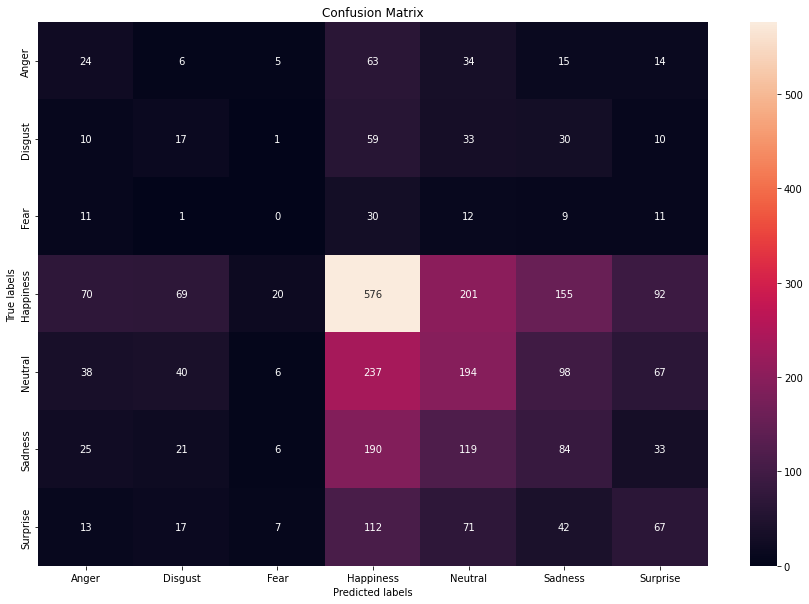

In [ ]:
### REFERENCE ###
# Code for confusion matrix adapted from https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels#
cm = metrics.confusion_matrix(true_label, pred_label)
fig, ax= plt.subplots(figsize=(15,10))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']); ax.yaxis.set_ticklabels(['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']);
plt.savefig('MLPCm.png')

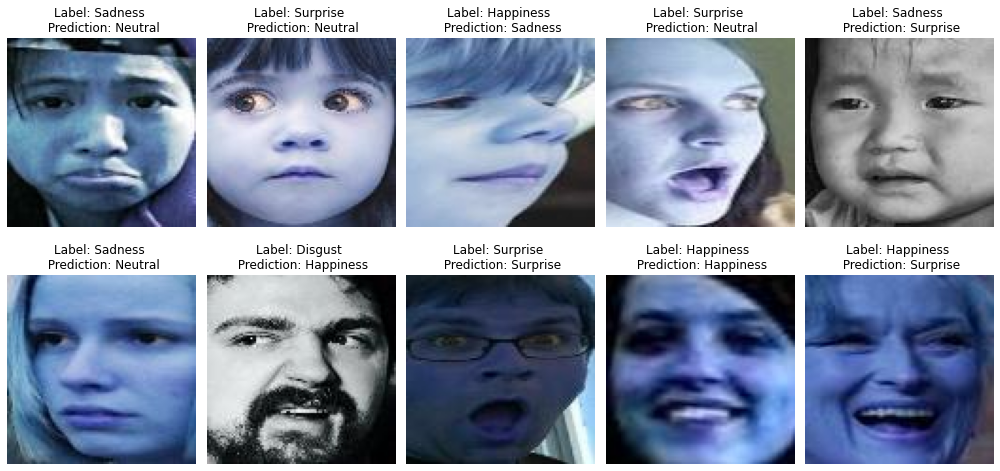

In [ ]:
### REFERENCE ##
### The following SIFT code was adapted from Lab_07 of the Computer Vision Module at City, University of London ###
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(x_test[i])
    ax[i].set_title(f'Label: {true_label[i]} \n Prediction: {pred_label[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.savefig('MLPQual.png')
plt.show()